In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import matplotlib.patches
from sklearn.decomposition import NMF, PCA
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans
import seaborn as sns

# specific packages to import from Bio
from Bio import Phylo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Phylo.TreeConstruction import *
from Bio.Align import MultipleSeqAlignment
from Bio.Cluster import *

In [2]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### Pre-processing mouse data
Load the two sets of mice data.

In [3]:
### Load the data
#(1) Healthy mice
with open('data/mouse_set_1_data.pkl', 'rb') as handle:
    mouse_set_1 = pickle.load(handle)     
#(2) IBD mice
with open('data/mouse_set_2_data.pkl', 'rb') as handle:
    mouse_set_2 = pickle.load(handle) 
    
### pull out the dictionaries
#(1) Healthy mouse
reads_healthy = mouse_set_1['reads']
qpcr_healthy = mouse_set_1['qpcr']
otu_taxonomy_healthy = mouse_set_1['otu_taxonomy']
times_healthy = mouse_set_1['times']
#(2) IBD mouse
reads_ibd = mouse_set_2['reads']
qpcr_ibd = mouse_set_2['qpcr']
otu_taxonomy_ibd = mouse_set_2['otu_taxonomy']
times_ibd = mouse_set_2['times']

### pertubation time point
high_fat = [21.5,28.5]
gram_pos = [35.5,42.5]
gram_neg = [50.5,57.5]
pertubation = high_fat.copy()
pertubation.extend(gram_pos)
pertubation.extend(gram_neg)

# Clustering of OTUs: using direct temporal correlations & the correlations of MNF factors scores that reflect temporal changes

In this notebook, we want to determine clusters of OTUs based on the **time-series correlations** of these OTUs. We applied two methods that can reflect the temporal changes:
- **Method1**: The direct correlations between every pair of OTU time courses. 
- **Method2**: First, we performed NMF(non-negative matrix factorization) on time courses with 6 factors. Then we calculated the correlations between every pair of OTUs' scores on the 6 factors.

Then, we can use these correlation matrices to assign cluster memberships with the k-medoids clustering method, described further below. But for now, let's prepare our time-series data.

## Part I. Time Series of OTUs Averaged over Mice within the Group

In the EDA part, we use NMF compared the concatenated time courses from all mice with the **time courses averaged over mice**, and the factors' trajectories showed little difference. Thus, we decided to average the time courses over all mice within the same group. This will generate one time course for each OTU.

The **abundance** we used is absolute aboundance of each OTU, take OTU_1 for example: 

absolute aboundance of OTU_1 =$\frac{\# OTU\_1}{\sum\#OTUs} * qpcr $

In [4]:
### Funciton to calculate absolute amount of each OTU
def absolute_OTU_count(reads, qpcr, times):
    all_abs_amount = []
    all_mice = list(reads.keys())
    for mouse_id in all_mice:
        mouse_reads_df = reads[mouse_id]
        m_total_amount = qpcr[mouse_id]['mean'].values
        all_OTU = list(mouse_reads_df.index)
        
        m_reads_values=reads[mouse_id].values
        m_reads_values_sum=sum(m_reads_values)
        m_all_abs_amount = np.zeros((len(all_OTU), len(times)))
        
        for idx, otu in enumerate(all_OTU):
            these_reads = mouse_reads_df.loc[otu]
            # relative abundance for each OTU
            this_relative_abundance = these_reads.values/m_reads_values_sum 
            # relative aboudance(reads) * total counts(qpcr)
            this_abs_abundance = this_relative_abundance * m_total_amount   
            m_all_abs_amount[idx,:] = this_abs_abundance
        
        all_abs_amount.append(m_all_abs_amount)
        
    # average over mice
    mean_abs_amount = np.mean(np.stack(all_abs_amount),axis = 0)
    return mean_abs_amount

In [5]:
### Funciton to store the Time Series in DataFrame
def put_time_series_in_DF(abs_time_series, group, times, reads):
    
    # for healthy group
    if group=='healthy':
        mouse_id = '2' # random pick one healthy mouse
        mouse_reads_df = reads[mouse_id] # get the index for OTU from this mouse
        df = pd.DataFrame(abs_time_series, index=mouse_reads_df.index.values, columns=times)
        
    # for ibd group
    else:
        mouse_id = '10' # random pick one ibd mouse
        mouse_reads_df = reads[mouse_id] # get the index for OTU from this mouse
        df = pd.DataFrame(abs_time_series, index=mouse_reads_df.index.values, columns=times)
        
    return df

Since the aboundance of different OTUs vary too much, we log-transformed the aboundance to force them into similar scale. Since the NMF process reqires the sboundance to be non-negative, we forced the "-inf" values to be 0.

In [8]:
### Function to log-transform the data
def log_transfrom(df):
    df_new = df.copy()
    # Natural Log transformation 
    df_new = df_new.transform(lambda x: np.log(x))
    # impute inf with 0
    df_new = df_new.replace([np.inf, -np.inf], 0)

    return df_new

In [9]:
### Extrat Time Series of absolute abundance OTUs
#(1) Healthy Mice
abs_healthy = absolute_OTU_count(reads_healthy, qpcr_healthy, times_healthy)
#(2) IBD Mice
abs_ibd = absolute_OTU_count(reads_ibd, qpcr_ibd, times_ibd)

### Store them into DataFrame
#(1) Healthy Mice
df_abs_healthy = put_time_series_in_DF(abs_healthy, 'healthy', times_healthy, reads_healthy)
df_abs_healthy.to_pickle("data/df_abs_healthy.pkl") # save it
#(2) IBD Mice
df_abs_ibd = put_time_series_in_DF(abs_ibd, 'ibd', times_ibd, reads_ibd)
df_abs_ibd.to_pickle("data/df_abs_ibd.pkl") # save it

### Log-10 tranform the data
df_log_healthy = log_transfrom(df_abs_healthy)
df_log_healthy.to_pickle("data/df_log_healthy.pkl") # save it
df_log_ibd = log_transfrom(df_abs_ibd)
df_log_ibd.to_pickle("data/df_log_ibd.pkl") # save it

### Get the distance matrix
#(1) Healthy Mice
D_time_healthy = pairwise_distances(df_log_healthy, metric='euclidean')
#(2) IBD Mice
D_time_ibd = pairwise_distances(df_log_ibd, metric='euclidean')

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [10]:
display(df_log_healthy.head())
print(df_log_healthy.shape)

,0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,...,58.5,59.0,59.5,60.0,60.5,61.0,62.0,63.0,64.0,64.5
OTU_1,15.612334,18.005759,22.641606,18.513872,18.811472,19.462919,20.406851,22.468613,21.841536,21.825574,...,21.849566,21.410641,21.527778,22.158153,21.497939,21.581831,22.011034,20.129698,21.379970,22.060020
OTU_2,14.848919,16.624145,22.609163,22.049754,21.884625,22.029704,21.906843,23.090238,21.638307,21.826581,...,22.590584,22.347643,22.105603,22.575106,22.658509,22.716880,23.401221,22.163510,23.314004,23.650318
OTU_3,10.479508,14.653883,17.266964,16.308436,16.929089,16.811438,17.311280,18.681248,17.798637,17.243159,...,17.938190,17.194515,16.310739,17.886093,17.788858,18.053215,17.913424,16.818332,17.801588,18.235767
OTU_4,12.272365,12.481222,17.731775,17.647981,19.062044,19.429198,19.859877,21.375936,20.900506,21.005380,...,24.458639,24.158390,24.135884,24.550475,23.930288,23.971715,24.660330,22.824187,23.599472,24.290684
OTU_5,11.441739,16.152485,20.180587,18.059108,20.832255,22.069384,22.598036,23.361916,22.545479,22.409905,...,13.236271,16.116812,15.308085,16.111319,17.096553,22.497035,23.794072,22.652196,22.918825,22.668927


(202, 75)


In [11]:
display(df_log_ibd.head())
print(df_log_ibd.shape)

,0.0,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,...,58.5,59.0,59.5,60.0,60.5,61.0,62.0,63.0,64.0,64.5
OTU_1,15.038261,23.295684,24.400763,23.773534,23.672181,22.864532,23.286296,23.752684,23.238813,22.811697,...,23.935337,24.477171,23.083840,23.655608,23.892105,23.942027,24.231726,24.497198,23.867408,24.014221
OTU_2,15.140231,21.031210,22.818192,23.052386,23.279235,22.375560,22.917239,23.507736,23.042411,22.567241,...,23.956038,24.293965,23.487941,22.853977,23.591083,23.418966,23.282756,23.278586,23.408605,23.733585
OTU_3,13.289146,16.029365,20.080456,22.934031,23.606432,22.717156,23.344217,23.663888,23.381910,22.498145,...,20.736306,20.782318,20.889707,21.441296,22.087629,23.185568,23.002551,23.137071,22.918885,23.537471
OTU_4,12.898236,14.904471,16.502411,14.946888,13.483837,13.769893,15.680838,15.515297,0.000000,13.619882,...,18.939606,17.968139,18.280294,17.728018,17.315986,18.125839,17.962274,22.277396,17.766311,17.991267
OTU_5,12.943279,14.352707,17.303419,16.485052,15.317998,15.788952,16.327652,16.357091,15.406699,15.334987,...,14.410325,0.000000,13.600884,14.746965,15.567702,14.896919,14.940048,15.949139,15.233658,15.409086


(176, 73)


## Part II. NMF
We applied non-negative matrix factorization (NMF) to decompose the time-series components among all OTUs. NNMF will decompose the changes in time-series into multiple factors. For each factor, every OTU will has a score describing how the factor explains that OTU. 

After trying the different number of scores, we found 6 factors can distinguish the pertubation pretty well, thus we used NMF to decomposed every time-series into 6 factors. In this way, each OTU would have 6 factor scores.

After getting the scores, for every pair of OTUs, we calculated the correlation between their 6 factor scores. Clustering will be performed on this distance matrix.

In [12]:
### Function to do the NMF
def NMF_plot_score(mean_abs, times, n_comp):
    model = NMF(n_components = n_comp)
    score = model.fit_transform(mean_abs.T)
    factors = model.components_
    
    fig,ax = plt.subplots(1,1,figsize = (8,6))
    ax.plot(times, score);
    y1,y2 = ax.get_ylim()
    ax.vlines(x = high_fat, ymin = y1*0.9, ymax = y2*1.1, color = 'yellow', linewidth = 0.5, linestyle = '--')
    ax.vlines(x = gram_pos, ymin = y1*0.9, ymax = y2*1.1, color = 'c', linewidth = 0.5, linestyle = '--')
    ax.vlines(x = gram_neg, ymin = y1*0.9, ymax = y2*1.1, color = 'm', linewidth = 0.5, linestyle = '--')
    
    rect1 = matplotlib.patches.Rectangle((high_fat[0],y1*0.9), high_fat[1]-high_fat[0],y2*1.1-y1*0.9, 
                                     color='yellow',alpha = 0.1)
    rect2 = matplotlib.patches.Rectangle((gram_pos[0],y1*0.9), gram_pos[1]-gram_pos[0],y2*1.1-y1*0.9, 
                                     color='c',alpha = 0.05)
    rect3 = matplotlib.patches.Rectangle((gram_neg[0],y1*0.9), gram_neg[1]-gram_neg[0],y2*1.1-y1*0.9, 
                                     color='m',alpha = 0.05)
    
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.add_patch(rect3)
    
    ax.set_ylim([y1*0.9, y2*1.1]);
    
    return factors

In [13]:
### Funciton to plot the scores
def plot_MNF_score(factors, n_comp):
    fig,ax = plt.subplots(1,1,figsize = (18,4))
    for i in range(n_comp):
        plt.bar(np.arange(1,21)+(i-n_comp/2+0.5)*0.15,factors[i,:20], width=0.15,label = 'factor {}'.format(i+1))
    plt.legend()
    ax.set(xticks = np.arange(1,21), xlabel='OTU #', ylabel = 'score', title='Composition of each factor');

Trajectories of the 6 factors


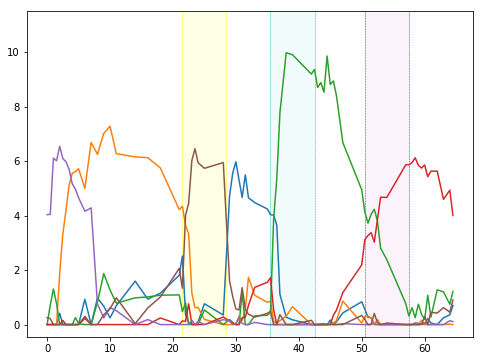

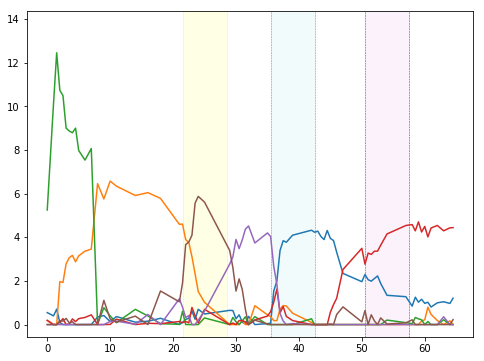

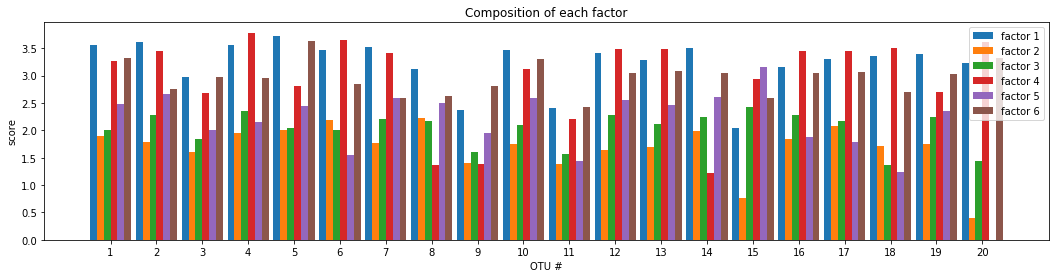

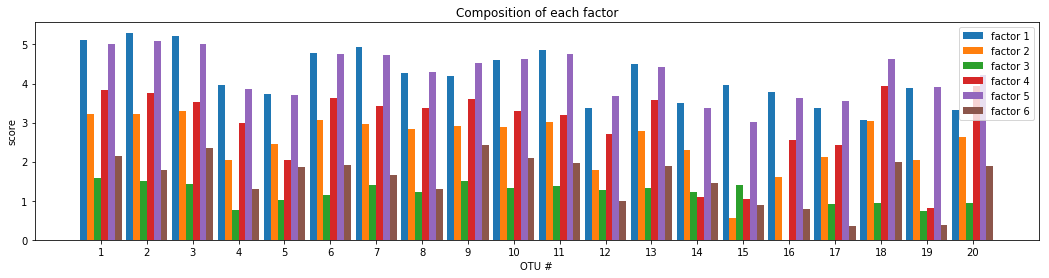

In [14]:
### Plot the NMF & get the factors
n_comp=6

#(1) Healthy Mice
print('Trajectories of the 6 factors')
factors_healthy = NMF_plot_score(df_log_healthy, times_healthy, n_comp)
#(2) IBD Mice
factors_ibd = NMF_plot_score(df_log_ibd, times_ibd, n_comp)
############################
# factors_healthy: 6 * 202 #
# factors_ibd: 6 * 176     #
############################

### Plot the score
#(1) Healthy Mice
plot_MNF_score(factors_healthy, n_comp)
#(2) IBD Mice
plot_MNF_score(factors_ibd, n_comp)

### Get the distance matrix
#(1) Healthy Mice
factors_healthy = factors_healthy.T
D_factors_healthy = pairwise_distances(factors_healthy, metric='euclidean')
#(2) IBD Mice
factors_ibd = factors_ibd.T
D_factors_ibd = pairwise_distances(factors_ibd, metric='euclidean')

In both healthy and IBD group, the trajectories of the 6 factors have non-overlapped peaks, thus 6 is a good choice of factors' number

## Part III. K-medoids Clustering

In [15]:
# define function to merge cluster IDs and visualize OTU abundances by clusters
def cluster_viz(df_abs, df_log, clusters):
    df_abs['clusterID'] = clusters # create new column of cluster IDs
    df_log['clusterID'] = clusters # create new column of cluster IDs
    
    print("Visualizing abundances over time by clusters:")
    df_abs.groupby(['clusterID']).mean().T.plot(kind='line', 
                                            title='Absolute Abundance Averaged by Cluster',
                                            figsize=(15,6))
    df_log.groupby(['clusterID']).mean().T.plot(kind='line', 
                                        title='Log-transformed Abundance Averaged by Cluster',
                                        figsize=(15,6))
    plt.show()

### Method 1: Cluster on MNF Scores

In [16]:
import os
# This can make the kernel die if it doesn't go well
os.environ['R_HOME'] = "/usr/share/anaconda3/lib/R"

from rpy2.robjects.packages import importr
r_factoextra = importr('factoextra')
# load once per notebook
%load_ext rpy2.ipython

#### StepA. Choose the cluster number
#### 1. Healthy Group

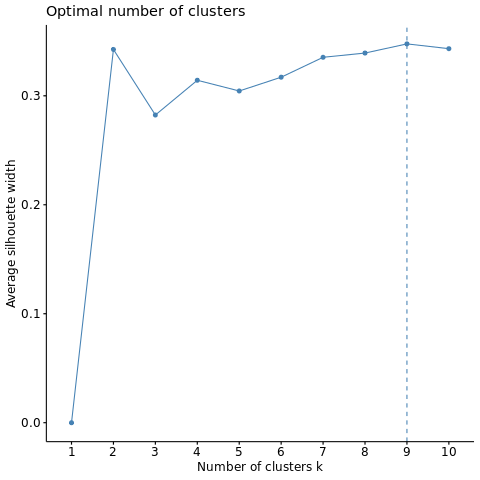

In [17]:
%%R -i factors_healthy
fviz_nbclust(factors_healthy, kmeans, method="silhouette", nstart = 147)

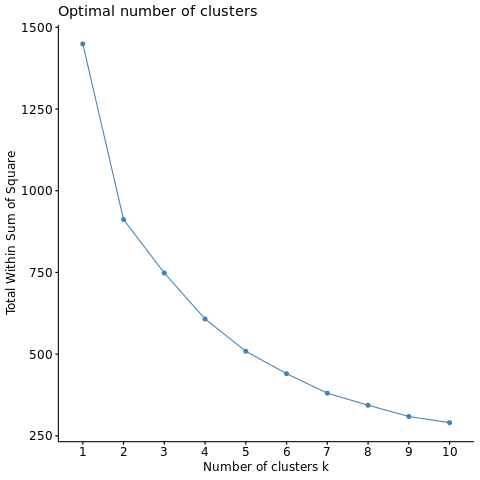

In [18]:
%%R -i factors_healthy
fviz_nbclust(factors_healthy, kmeans, method="wss", nstart = 147)

Combine the information from both silhouette and elbow plots, we chose the K=9.
#### 2. IBD group

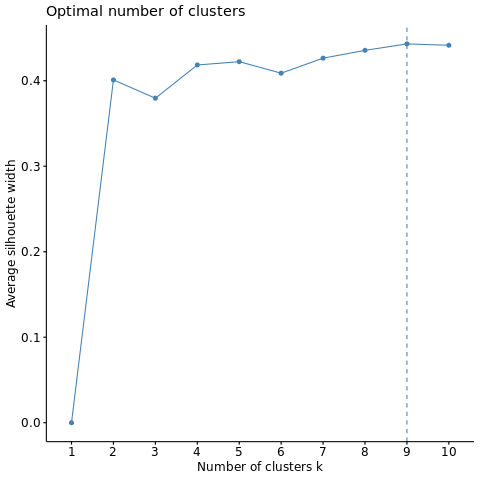

In [19]:
%%R -i factors_ibd
fviz_nbclust(factors_ibd, kmeans, method="silhouette", nstart = 147)

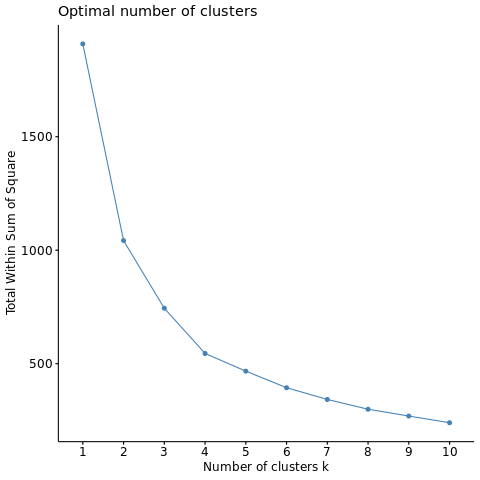

In [20]:
%%R -i factors_ibd
fviz_nbclust(factors_ibd, kmeans, method="wss", nstart = 147)

Combine the information from both silhouette and elbow plots, we chose the k=9
#### Step B. Do the clustering
#### (1) Healthy Mice

In [23]:
### k-medoid clustering 
kmedoids_factors_healthy, kmedoids_factors_healthy_err, _ = kmedoids(D_factors_healthy, nclusters=9, npass=800)
print(kmedoids_factors_healthy)
print("---")
print("Within-cluster sum of distances:", kmedoids_factors_healthy_err)

# save clusterIDs as a pickle file
pickle.dump( kmedoids_factors_healthy, open( "OTU_NMF_healthy.p", "wb" ) )

[  2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2 113   2   2 144   2 113 169 138 169 121 144 121   2 113 121   2   2
 137 121 169 138 138   2 113 138 138   2 121 113 138 144 113 138 137   2
 138 144 138 138 121   2 144 169   2 138 113 121   2 144 113 137 144 137
 138 113 113 121 144 138 121   2 137 138 121 138 144 113 138 138 144 113
 136 144 138 138 169 137 136 194 113 138 194 169 121 144 144 144 138 138
 136 169 137 121 138 113 144 144 138 194 144 138 121 121 194 144 136 138
 169 136 113 138 144 136 113 144 137 169 136 137 138 144 169 169 138 144
 144 137 138 169 169 144 169 144 169 136 144 138 169 113 137 194 169 138
 169 121 113 136 121 169 121 169 136 121 136 136 169 136 137 194 113 194
 137 169 136 194 169 194 138 136 194 194 194 136 194 136 194 194 194 169
 137 194 136 136]
---
Within-cluster sum of distances: 241.00158792378474


Visualizing abundances over time by clusters:


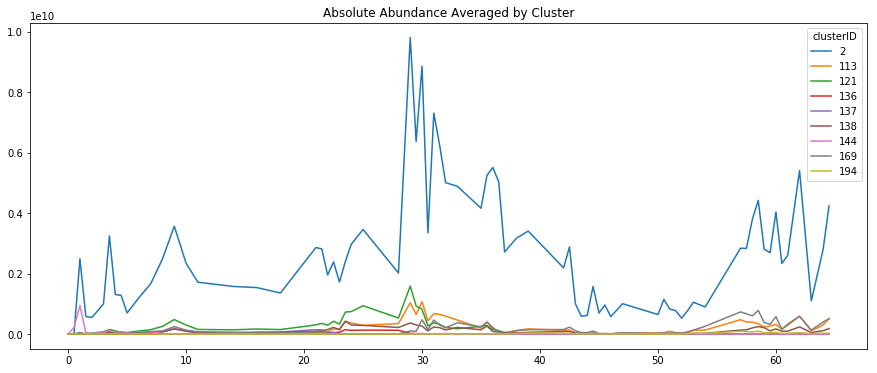

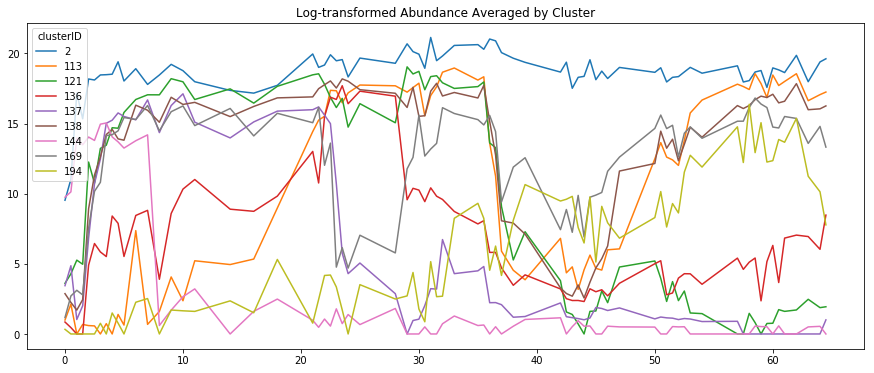

In [24]:
cluster_viz(df_abs_healthy, df_log_healthy, kmedoids_factors_healthy)

#### (2) IBD Mice

In [25]:
### K-Medoids
kmedoids_factors_ibd, kmedoids_factors_ibd_err, _ = kmedoids(D_factors_ibd, nclusters=9, npass=800)
print(kmedoids_factors_ibd)
print("---")
print("Within-cluster sum of distances:", kmedoids_factors_ibd_err)

# save clusterIDs as a pickle file
pickle.dump( kmedoids_factors_ibd, open( "OTU_NMF_ibd.p", "wb" ) )

[ 21  21  21 128 128  21  21  21  21  21  21 128  21 128 128 128 128  21
 128  21  21  21  21 128  21  21  88  21  64 143  64  21  21  21 128  94
  77  88  77  77  64 159  64  88  88  77  77 143  77  88  77  64 128 128
 143 143  64 128  77  77 128 128 128  88  64  77  88  77 130  88  88  94
 143  88 128  64  64  77  77 159  88  94 128 143  77  64  64  88  88 159
 143  77 128  88  94  64  88  77 128  94  64 159  64  88 143  94  64 128
 159 143  88 143 143 143  64 128  64 143 159  64 143 130 143 159  64 159
 143 159 128  94 130  88 128 130  88 143 143 159  64 159  64 143  64 143
  88  94 159 130  64 130  64 143 143 159  88 143 143 130  77 159 159 143
  64  64  64  64 143  64 143  64 143 159  94  94 128 143]
---
Within-cluster sum of distances: 205.22644036122378


Visualizing abundances over time by clusters:


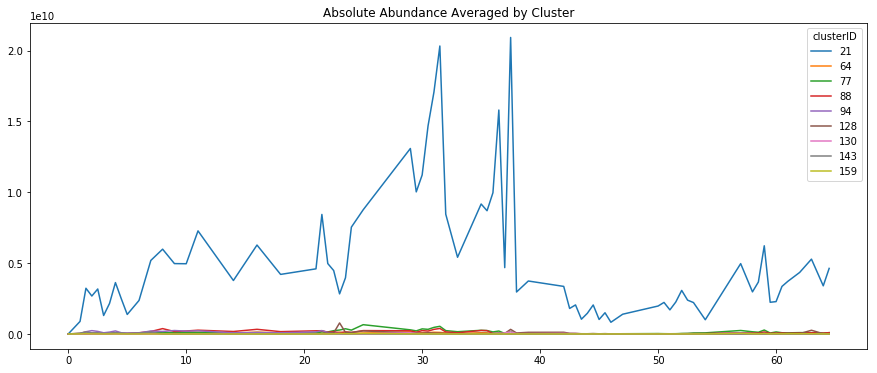

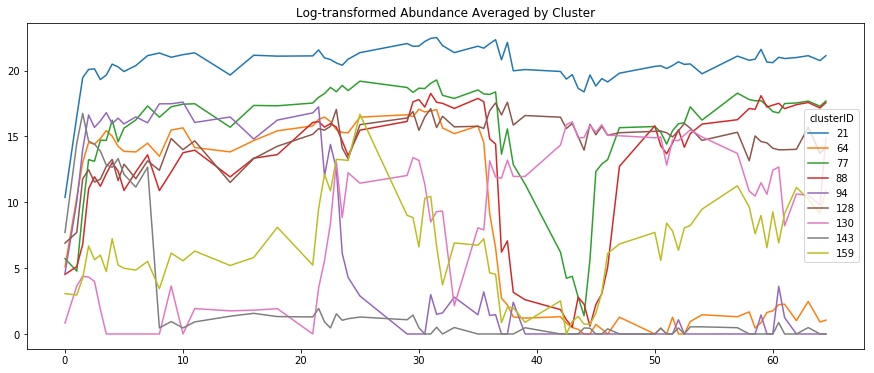

In [26]:
cluster_viz(df_abs_ibd, df_log_ibd, kmedoids_factors_ibd)

### Method 2: Cluster on direct temporal correlations
#### StepA. choose the cluster number
#### (1) Healthy Group

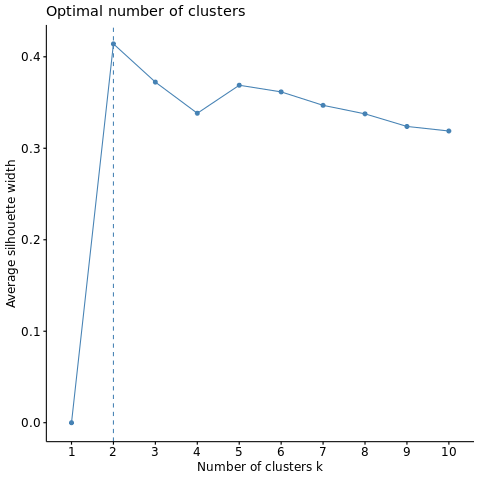

In [27]:
%%R -i D_time_healthy
fviz_nbclust(D_time_healthy, kmeans, method="silhouette", nstart = 147)

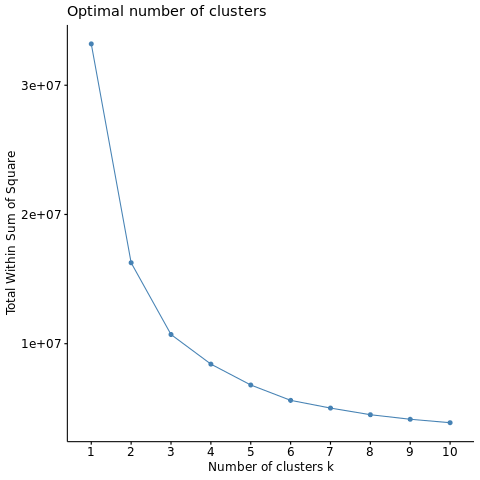

In [28]:
%%R -i D_time_healthy
fviz_nbclust(D_time_healthy, kmeans, method="wss", nstart = 147)

Thus, I choose the k=5
#### (2) IBD group

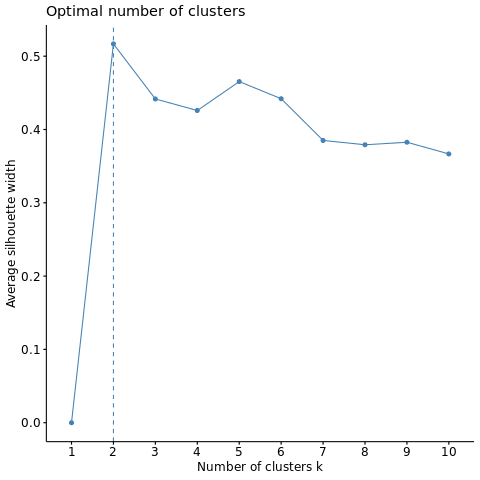

In [29]:
%%R -i D_time_ibd
fviz_nbclust(D_time_ibd, kmeans, method="silhouette", nstart = 147)

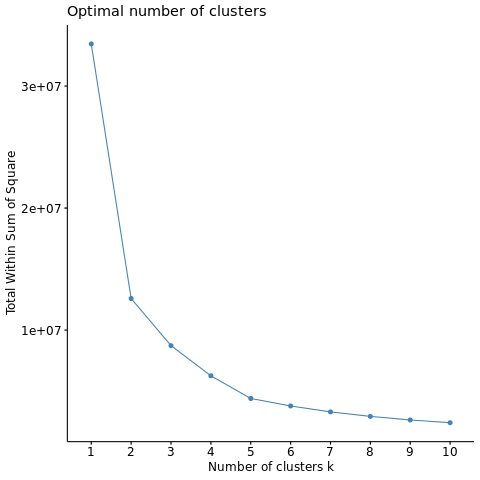

In [30]:
%%R -i D_time_ibd
fviz_nbclust(D_time_ibd, kmeans, method="wss", nstart = 147)

Thus I choose k=5 as number of culsters
#### StepB. Do the clustering
#### (1) Healthy Mice

In [31]:
### K-Medoids
kmedoids_time_healthy, kmedoids_time_healthy_err, _ = kmedoids(D_time_healthy, nclusters=5, npass=800)
print(kmedoids_time_healthy)
print("---")
print("Within-cluster sum of distances:", kmedoids_time_healthy_err)

# save clusterIDs as a pickle file
pickle.dump( kmedoids_time_healthy, open( "OTU_time_healthy.p", "wb" ) )

[  2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2 138   2   2 115   2 138   2 138   2 168 115 168   2   2 138   2   2
 115 168   2 138 138   2 138   2 138   2 168 178   2 115 178   2 168   2
 138 115   2 138 138   2 115   2   2 138 138 168   2 115   2 168 115 168
 138 138 138 168 115 138 168   2 168 138 168 138 115 178 138 138 115 178
 168 115 138 138   2 168 138 178 178   2 178   2 168 115 115 115 138 138
 168   2 115 168 138 178 115 115 138 178 115 138 168 168 178 115 168 138
 138 115 178 138 115 138 178 115 168 138 168 168 138 115 138 138 138 115
 115 115 138 138 138 115 138 115 138 138 115 138 138 178 115 178 138 138
 138 168 178 178 168 178 168 138 168 168 168 168 138 168 115 178 178 178
 115 138 168 178 168 178 138 115 178 178 178 178 178 168 178 178 178 168
 168 178 168 168]
---
Within-cluster sum of distances: 10182.714824250726


Visualizing abundances over time by clusters:


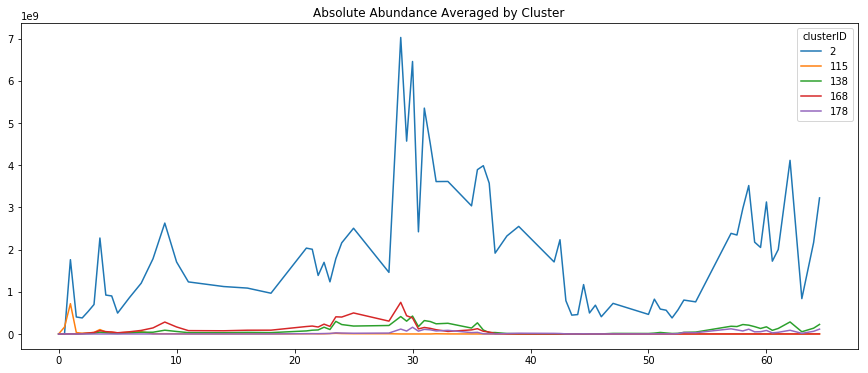

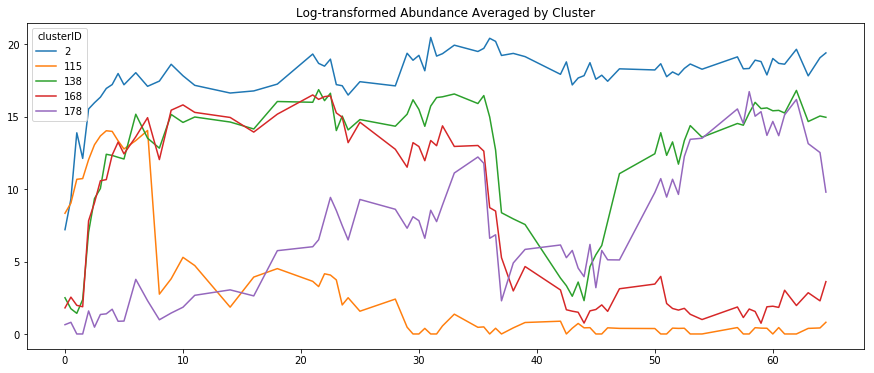

In [32]:
cluster_viz(df_abs_healthy, df_log_healthy, kmedoids_time_healthy)

#### (2) IBD Mice

In [33]:
### K-Medoids
kmedoids_time_ibd, kmedoids_time_ibd_err, _ = kmedoids(D_time_ibd, nclusters=5, npass=800)
print(kmedoids_time_ibd)
print("---")
print("Within-cluster sum of distances:", kmedoids_time_ibd_err)

# save clusterIDs as a pickle file
pickle.dump( kmedoids_time_ibd, open( "OTU_time_ibd.p", "wb" ) )

[ 21  21  21 115 115  21  21  21  21  21  21 115  21 115 115 115 115  21
 115  21  21  21  21 115  21  21 115  21 138 143 138  21  21  21 115 138
 115 144 115 115 138 144 138 115 115 115 115 143 115 115 115 138 115 115
 143 143 138 115 115 115 115 115 115 115 138 115 115 115 115 115 144 138
 143 144 115 138 138 115 115 138 115 138 115 143 115 138 138 115 115 144
 143 115 115 115 143 138 115 115 115 143 138 138 138 115 143 143 138 144
 138 143 115 143 143 143 138 115 138 143 144 138 143 115 143 143 138 144
 143 143 115 143 144 115 115 144 144 143 143 144 138 144 138 143 138 143
 144 143 144 144 138 144 138 143 143 144 144 143 143 144 115 138 144 143
 138 138 138 138 143 138 143 138 143 138 138 143 115 143]
---
Within-cluster sum of distances: 7049.410060877262


Visualizing abundances over time by clusters:


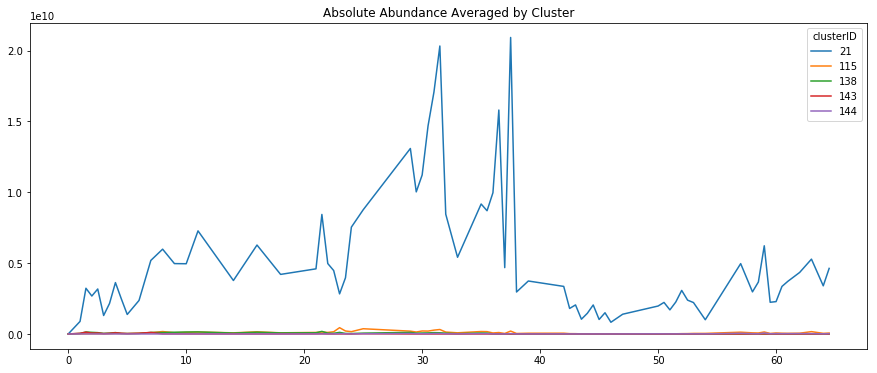

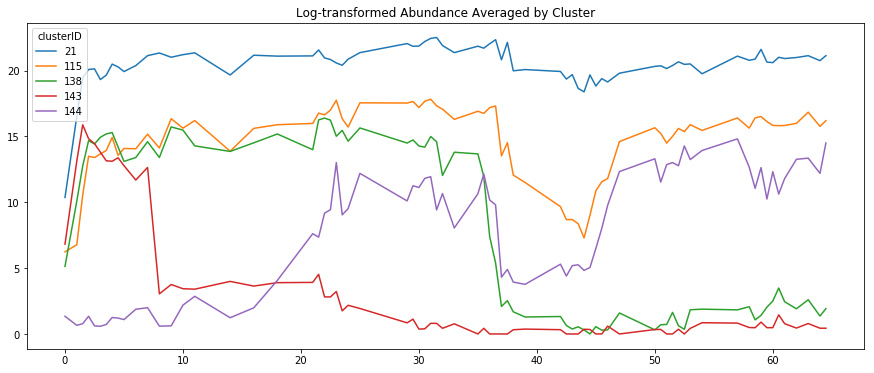

In [34]:
cluster_viz(df_abs_ibd, df_log_ibd, kmedoids_time_ibd)

### Summary 

From the trajectories above, we can see all of the clusters can distinguish the time-series well (non-overlapped trajectories). Since the time is limitted, we chose the NMF for later model taining, because it has 9 clusters, giving more information..